# BERT Sentiment analysis on Amazon Cell Phones Reviews

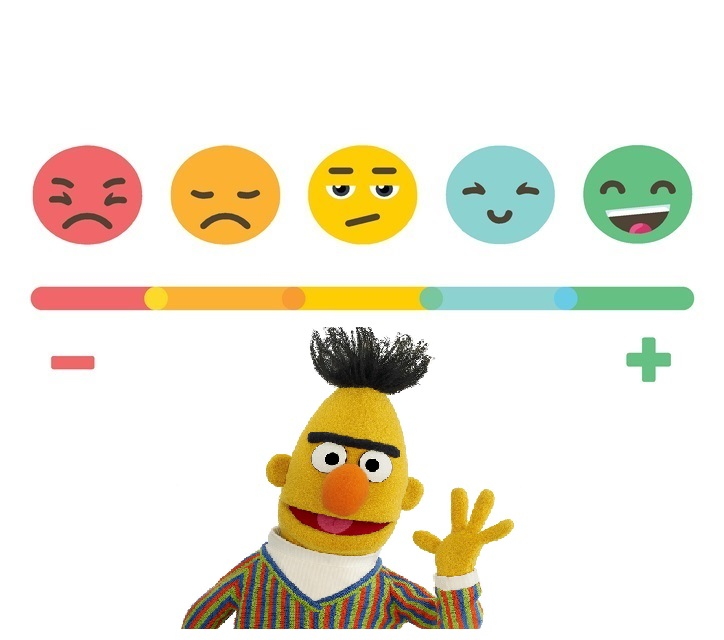

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mrvmurali","key":"b52d02bd18b2eed468ba2144e5ad2c6b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d grikomsn/amazon-cell-phones-reviews

amazon-cell-phones-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip "/content/amazon-cell-phones-reviews.zip"

Archive:  /content/amazon-cell-phones-reviews.zip
replace 20191226-items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 20191226-reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Importing the Required Libraries

In [3]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [4]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils
import string,re

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [5]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


 ## pre-process the review data

In [6]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



## Read the data

In [7]:
review_data= pd.read_csv("/content/20191226-reviews.csv")
review_data.head(10)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,J. White,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,the cell phone store owner,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,Matt,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,Charles Cook,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,Amazon Customer,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [8]:
print("The dataset contains {0[0]: .0f} rows and {0[1]: .0f} variables.".format(review_data.shape))

The dataset contains  67986 rows and  8 variables.


In [9]:
review_data["reviewText"]=review_data['title']+review_data["body"]

In [10]:
review_data = review_data.rename(columns = {'overall': 'rating', 'asin': 'productID'}, inplace = False)

In [11]:
review_data.dropna(axis = 0, how ='any',inplace=True) 

In [12]:
review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

In [13]:
print(review_data['rating'].value_counts())

5    12960
1     7061
4     3280
3     2032
2     1873
Name: rating, dtype: int64


In [14]:
print(len(review_data))
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))

27206
Train Max Sentence Length :4249


In [15]:
review_data['Num_words_text'].describe()

count    27206.000000
mean        74.670440
std        129.866469
min          0.000000
25%         17.000000
50%         38.000000
75%         81.000000
max       4249.000000
Name: Num_words_text, dtype: float64

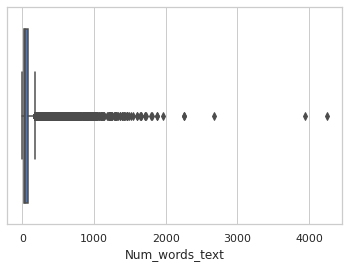

In [16]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

## create train and test datasets

In [17]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

No of Short reviews
14036


In [18]:
mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Long reviews
5287


In [19]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0

In [20]:
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())

11406
5    4891
1    3348
4    1378
3     929
2     860
Name: rating, dtype: int64


In [21]:
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

Train data
1    7198
0    4208
Name: sentiment, dtype: int64


In [22]:
#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())

20926
5    10199
1     5679
4     2279
3     1450
2     1319
Name: rating, dtype: int64


In [23]:
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())

Test data
1    13928
0     6998
Name: sentiment, dtype: int64


In [24]:
train_data['sentiment'].value_counts()

1    7198
0    4208
Name: sentiment, dtype: int64

In [25]:
sample_size = int(len(train_data)*0.5)
sampleDf = train_data.sample(sample_size, random_state=23)

In [26]:
from collections import Counter

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(sampleDf['reviewText'].values,\
                                                      sampleDf['sentiment'].values,\
                                                      test_size=0.3,\
                                                      stratify = sampleDf['sentiment'].values,\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:3992
Class distributionCounter({1: 2533, 0: 1459})
Valid data len:1711
Class distributionCounter({1: 1085, 0: 626})


## Tokenization

In [28]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [29]:
## vocab_file reads the vocab file associated to the downloaded model.
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()


## do_lower_case reads binary variable which if True means tokenizer will reformat all text to 
##lower case rendering model to be NOT case sensitive. Should be False by default. 
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()




## tokenizer builds tokenizer using variables 1 and 2.
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [30]:
do_lower_case

False

## add CLS,SEP tokens

In [31]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [32]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

review = tf.ragged.constant([
    encode_names(n) for n in X_train])

In [33]:
print('Tokenized Reviews shape', review.shape.as_list())

Tokenized Reviews shape [3992, None]


In [34]:
review[0]

<tf.Tensor: shape=(43,), dtype=int32, numpy=
array([11695, 11695, 11695, 57643, 12103, 19503, 15148, 10169, 31237,
       10893, 15362, 11003, 16624, 10105, 31311, 15541, 56237, 14446,
       10105, 62006, 41008, 10529, 17038, 10374, 10169, 31311, 15541,
       10379, 76738, 43662, 30181, 10198, 18676, 10169, 10189, 12415,
       13028, 11758, 11760, 42536, 40843, 14772,   102], dtype=int32)>

In [35]:
X_train[0]

'long long long battery lifeill start with why only gave three star the talk text awful the worst phone have ever had with talk text also spell check really sucks with that said you dont use everything else great'

In [36]:
tokenizedReview = tokenizer.tokenize(X_train[0])
for i in tokenizedReview:
  print(i, tokenizer.convert_tokens_to_ids([i]))

long [11695]
long [11695]
long [11695]
battery [57643]
life [12103]
##ill [19503]
start [15148]
with [10169]
why [31237]
only [10893]
gave [15362]
three [11003]
star [16624]
the [10105]
talk [31311]
text [15541]
aw [56237]
##ful [14446]
the [10105]
worst [62006]
phone [41008]
have [10529]
ever [17038]
had [10374]
with [10169]
talk [31311]
text [15541]
also [10379]
spell [76738]
check [43662]
really [30181]
su [10198]
##cks [18676]
with [10169]
that [10189]
said [12415]
you [13028]
dont [11758]
use [11760]
everything [42536]
else [40843]
great [14772]


## Mask and input type

In [37]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*review.shape[0]
input_word_ids = tf.concat([cls, review], axis=-1)

In [38]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(review)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

## Remake into a function for normal use

In [39]:
lens = [len(i) for i in input_word_ids]

In [40]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 153


In [41]:
max_seq_length = int(1.6*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 244


In [42]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [43]:
def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [44]:
Xb_train = bert_encode(X_train, tokenizer, max_seq_length)
Xb_valid = bert_encode(X_valid, tokenizer, max_seq_length)

## Model Buliding 

In [45]:
num_class = 1  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

In [46]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

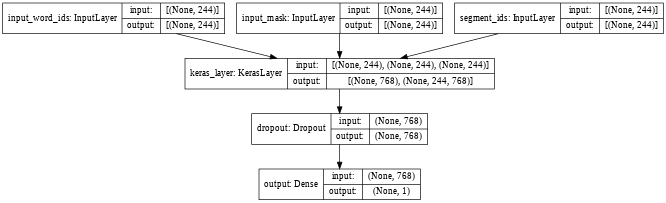

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [48]:
epochs = 2
batch_size = 16 # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [49]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 244)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 244)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 244)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
history = model.fit(Xb_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(Xb_valid, y_valid),
                    verbose=1)

Epoch 1/2
250/250 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3665 

In [ ]:
loss, accuracy = model.evaluate(Xb_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xb_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy)

In [ ]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['binary_accuracy'],'bo--', label=' training data')
    plt.plot(history.history['val_binary_accuracy'], 'ro--' ,label='validation data')
    plt.title('Accuracy for Text Classification')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label=' training data')
    plt.plot(history.history['val_loss'],'ro--' , label='validation data')
    plt.title('Loss for Text Classification')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()


In [ ]:
plot_accuracy_loss(history)